<a href="https://www.kaggle.com/code/samaasabry/sign-language-classification?scriptVersionId=147129350" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Understanding Our Data**

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

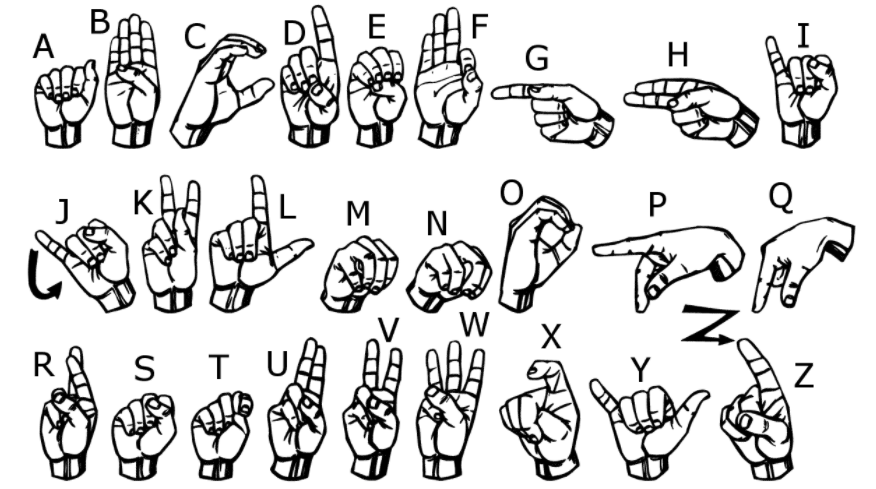

# **Importing Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Reading Data**

In [2]:
train_data=pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test_data=pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [3]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
None


In [4]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB
None


# **Data Visualization**

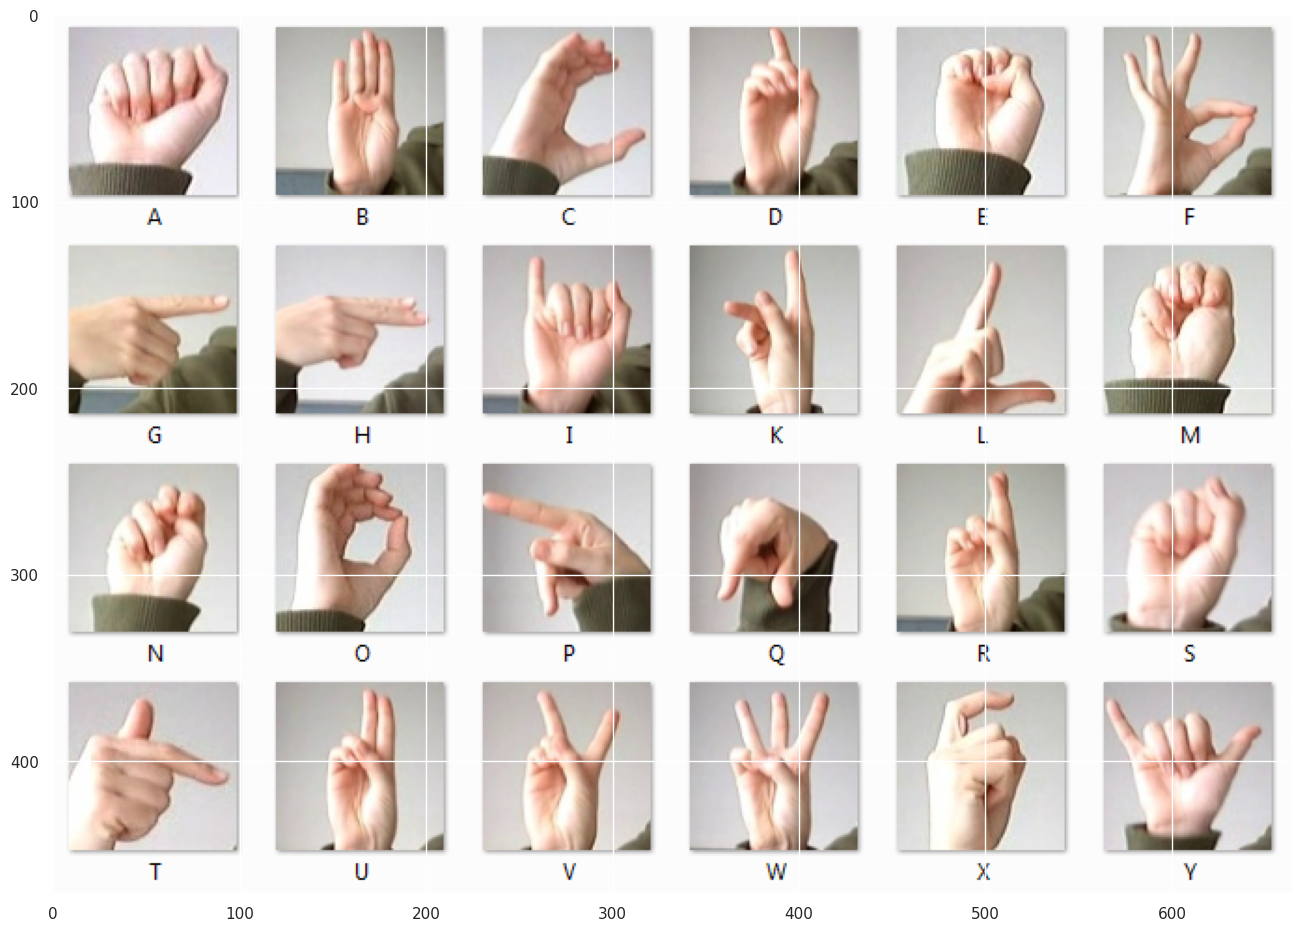

In [5]:
#The 24 classes 
plt.figure(figsize=(16,16))
img=plt.imread('/kaggle/input/sign-language-mnist/amer_sign2.png')
plt.imshow(img)
plt.show()

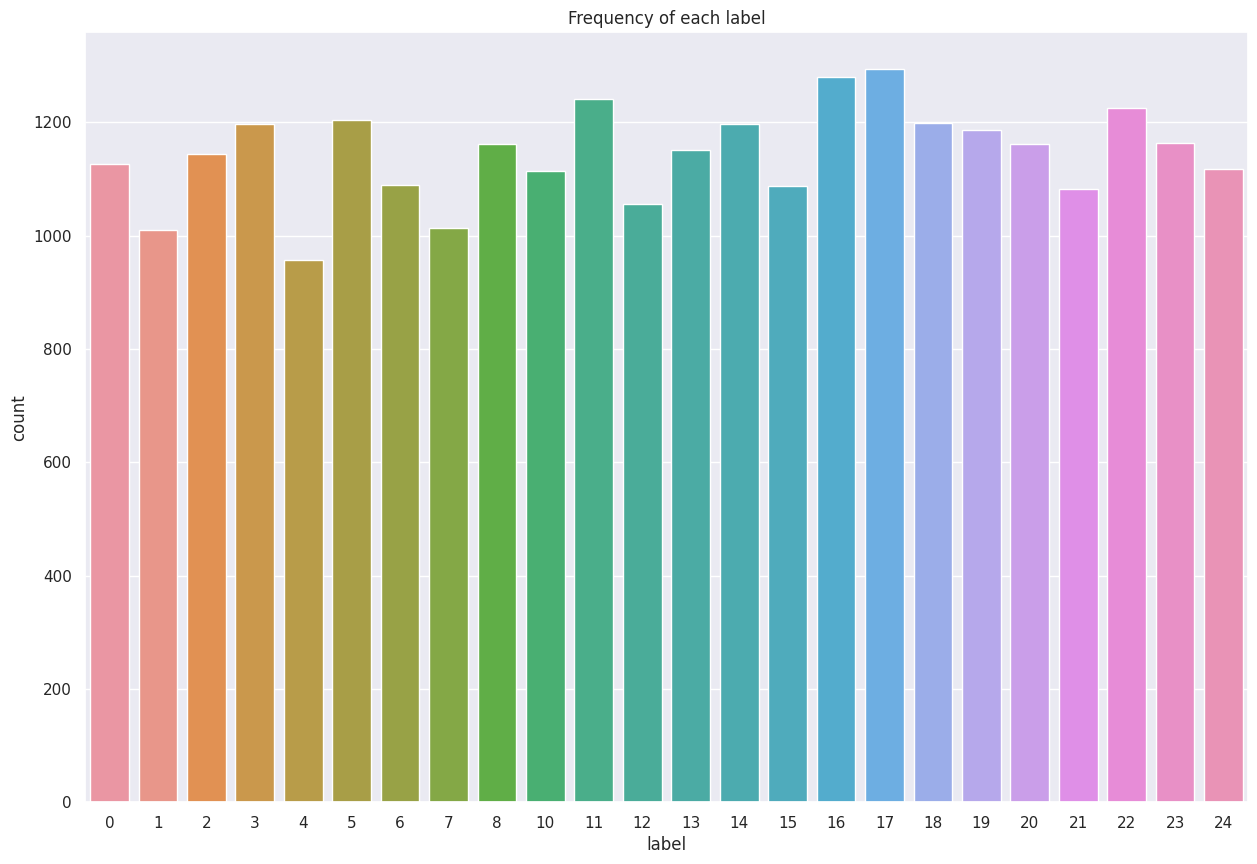

In [6]:
#Getting insights
plt.figure(figsize = (15,10))
sns.countplot(x=train_data['label'],data=train_data)
plt.title("Frequency of each label")
plt.show()

# **Preparing Data**

## **Splitting Data into features and target**

In [7]:
X_train=train_data.drop(['label'],axis=1)
y_train=train_data['label']

In [8]:
X_test=test_data.drop(['label'],axis=1)
y_test=test_data['label']

## **Reshaping** 

In [9]:
size=28
channels=1
batch=128
epochs=100

In [10]:
X_train=X_train.values.reshape(X_train.shape[0],size,size,channels)
X_train.shape

(27455, 28, 28, 1)

In [11]:
X_test=X_test.values.reshape(X_test.shape[0],size,size,channels)
X_test.shape

(7172, 28, 28, 1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# **Image Augmentation**


In [13]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenRescale = ImageDataGenerator(rescale=1./255)

X_train = datagen.flow(X_train, y_train, batch_size=batch)
X_val = datagen.flow(X_val, y_val)
X_test = datagenRescale.flow(X_test, y_test)

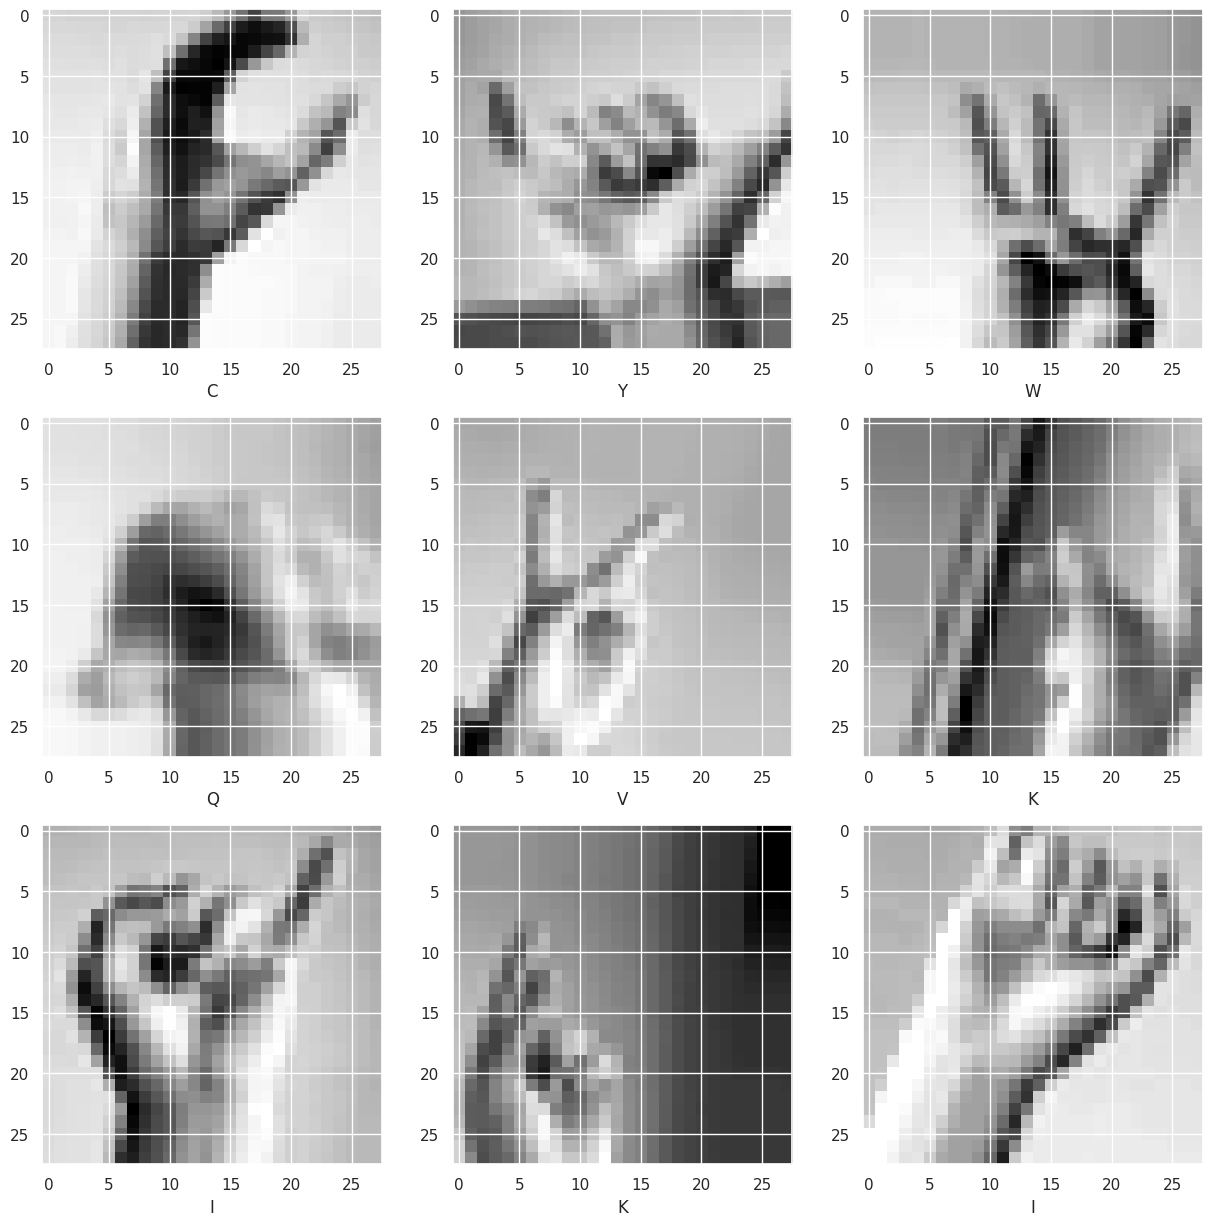

In [14]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in X_train:
        image = X_batch[i]
        plt.imshow(image, cmap='gray')
        plt.xlabel(alphabet[Y_batch[i]])
        break
plt.show()

# **Building Model Architecure**

In [15]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(size,size,channels)),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                 
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                    
                    
                    Flatten(),
                    
                    Dense(units=4096, activation="relu"),                 
                    Dropout(0.2),
                    
                    Dense(units=1024, activation="relu"),
                    Dropout(0.2),
                     Dense(units=256, activation="relu"),
                    Dropout(0.2),
                    
                    Dense(units=25, activation="softmax"),
])

In [16]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

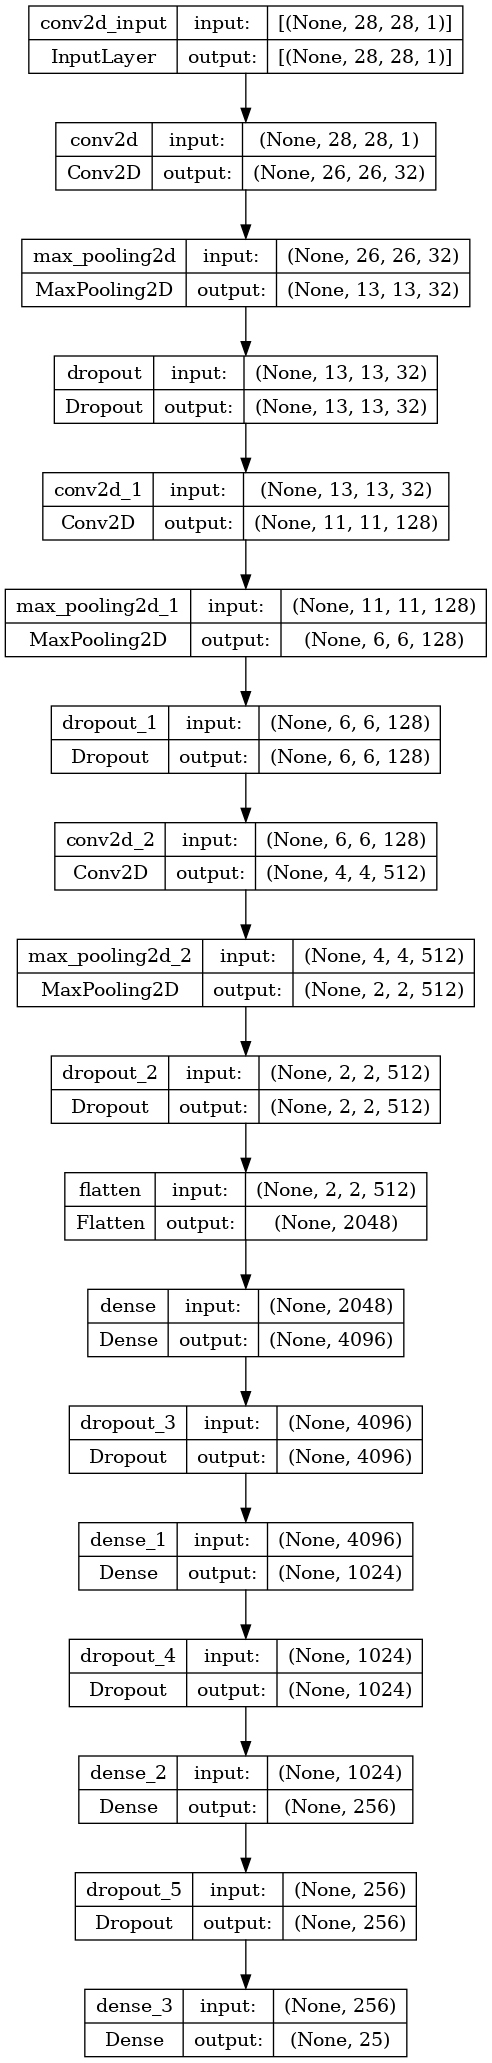

In [18]:
#Visualizng Model
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

# **Training Model**

In [19]:
#Callbacks to prevent overfitting
checkpoint_filepath = 'best_model.hdf5'

callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [callback_checkpoint]

In [20]:
history = model.fit(X_train,validation_data=X_val,epochs=15, callbacks=callbacks)

Epoch 1/15


2023-10-18 19:38:46.051889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


172/172 [==============================] - 29s 88ms/step - loss: 3.1229 - accuracy: 0.0578 - val_loss: 2.9679 - val_accuracy: 0.0776
Epoch 2/15
172/172 [==============================] - 14s 83ms/step - loss: 2.6135 - accuracy: 0.1610 - val_loss: 2.1445 - val_accuracy: 0.3091
Epoch 3/15
172/172 [==============================] - 14s 83ms/step - loss: 1.9528 - accuracy: 0.3443 - val_loss: 1.5278 - val_accuracy: 0.4618
Epoch 4/15
172/172 [==============================] - 14s 81ms/step - loss: 1.4657 - accuracy: 0.4876 - val_loss: 1.0876 - val_accuracy: 0.6241
Epoch 5/15
172/172 [==============================] - 14s 82ms/step - loss: 1.1783 - accuracy: 0.5879 - val_loss: 0.8263 - val_accuracy: 0.7041
Epoch 6/15
172/172 [==============================] - 14s 83ms/step - loss: 0.9850 - accuracy: 0.6552 - val_loss: 0.6763 - val_accuracy: 0.7603
Epoch 7/15
172/172 [==============================] - 14s 82ms/step - loss: 0.8445 - accuracy: 0.7035 - val_loss: 0.5400 - val_accuracy: 0.8152
Epo

In [21]:
loss,acc=model.evaluate(X_test)

225/225 [==============================] - 1s 4ms/step - loss: 0.0735 - accuracy: 0.9745


In [22]:
print('MODEL ACCURACY = {}%'.format(acc*100))

MODEL ACCURACY = 97.44840860366821%
